In [ ]:
%pip install -q -U gym
%pip install -q -U gym[classic_control, box2d, atari, accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 13.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.9 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.
ERROR: Invalid requirement: 'gym[classic_control,': Expected extra name after comma
    gym[classic_control,
                        ^


In [ ]:
import gym
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from IPython.display import HTML
from collections import deque
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.losses import MSE

[ 0.0273956  -0.00611216  0.03585979  0.0197368 ]


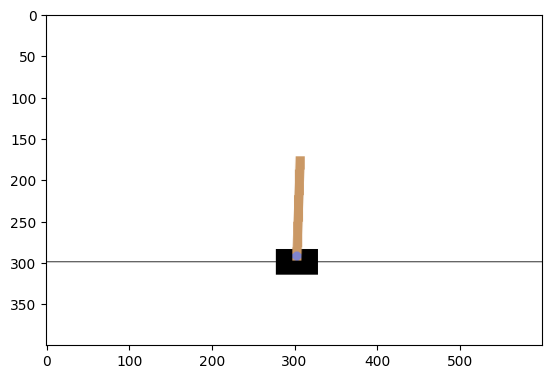

In [ ]:
env = gym.make("CartPole-v1", render_mode = "rgb_array")
obs, info = env.reset(seed=42)
print(obs) #horizontal position, cart velocity, pole angle, pole angular velocity
img = env.render() #creates an image
plt.imshow(img)

In [ ]:
env.action_space #2 possible actions

Discrete(2)

In [ ]:
action = 1 #accelerate right as pole is tilting to the right
obs, reward, done, truncated, info = env.step(action)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [ ]:
print(obs) #new observation/state of your system
print(reward) #+1 everytime - maximize by keeping it upright for longest possible time
print(done) #if tilted too much to one side (more than 12 degrees) or cart too much to the side
print(truncated) #if interrupted early
print(info) #extra version

[ 0.02727336  0.18847767  0.03625453 -0.26141977]
1.0
False
False
{}


In [ ]:
def basic_policy(obs): #goes to the left when leaning left and similar for right
    angle = obs[2]
    if angle < 0:
        return 0
    else:
        return 1

In [ ]:
totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode) #different seeds everytime
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break
    totals.append(episode_rewards)

In [ ]:
np.mean(totals), min(totals), max(totals) #never managed to do better than 63 steps with this basic policy

(41.698, 24.0, 63.0)

In [ ]:
def update_scene(num, frames, patch): #this box makes a nice little video
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=333):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

anim = show_one_episode(basic_policy)
HTML(anim.to_html5_video())

In [ ]:
input_shape = [4]
n_outputs = 2
model = Sequential([
    Input(shape=input_shape),
    Dense(32, activation = "elu"),
    Dense(32, activation = "elu"),
    Dense(n_outputs)
])

In [ ]:
def epsilon_greedy_policy(state, epsilon = 0): #choose random action with probability epsilon, otherwise choose best
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) #random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose = 0)[0]
        return Q_values.argmax()

In [ ]:
replay_buffer = deque(maxlen=2000)

In [ ]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [np.array([experience[field_index] for experience in batch]) for field_index in range(6)]
    #the six are states, actions, rewards, next_states, dones, truncateds

In [ ]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [ ]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

In [ ]:
batch_size = 32
discount_factor = 0.95
optimizer = Nadam(learning_rate = 0.01)
loss_fn = MSE

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose = 0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)
    target_Q_values = rewards + runs*discount_factor*max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis = 1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
for episode in range(600): #long-running cell, just under an hour on A100
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1-episode/500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)

Episode: 600, Steps: 200, eps: 0.010

In [ ]:
model.set_weights(best_weights)
anim2 = show_one_episode(epsilon_greedy_policy)
HTML(anim2.to_html5_video())

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


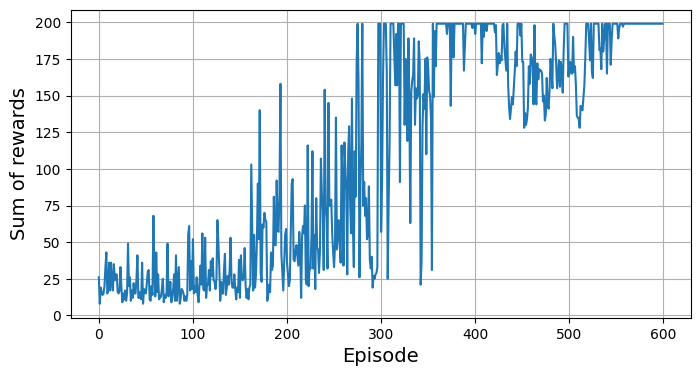

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()